# CSE 158 Assignment 2: Amazon Gift Card Review Rating Prediction

**Dataset:** Amazon Reviews 2023 - Gift Cards (50K Sample)  
**Task:** Predict star rating (1-5) from user, product, and review text  
**Student:** [Your Name]

---

## Table of Contents
1. [Task Definition](#section1)
2. [Exploratory Data Analysis](#section2)
3. [Feature Engineering](#section3)
4. [Model Training](#section4)
5. [Results & Analysis](#section5)

---

# Import libraries
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

# Plotting style - using modern style syntax
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

In [6]:
# Load reviews - UPDATE THESE PATHS to where you uploaded the files
print("Loading reviews...")
reviews = []

# Try multiple possible paths
import os

possible_review_paths = [
    'Gift_Cards.jsonl.gz',  # Current directory
    'Gift_Cards_jsonl.gz',
    'Gift_Cards_50k_sample.jsonl.gz',
    '/mnt/user-data/uploads/Gift_Cards_jsonl.gz',
    r'c:\Users\darko\OneDrive\Documents\GitHub\cse158-assignment2\Gift_Cards.jsonl.gz'
]

possible_meta_paths = [
    'meta_Gift_Cards.jsonl.gz',  # Current directory
    'meta_Gift_Cards_jsonl.gz',
    'meta_Gift_Cards_50k_sample.jsonl.gz',
    '/mnt/user-data/uploads/meta_Gift_Cards_jsonl.gz',
    r'c:\Users\darko\OneDrive\Documents\GitHub\cse158-assignment2\meta_Gift_Cards.jsonl.gz'
]

# Find existing files
review_path = None
meta_path = None

for path in possible_review_paths:
    if os.path.exists(path):
        review_path = path
        break

for path in possible_meta_paths:
    if os.path.exists(path):
        meta_path = path
        break

if review_path is None or meta_path is None:
    raise FileNotFoundError(
        f"Could not find data files. Please update the paths.\n"
        f"Looking for review file in: {possible_review_paths}\n"
        f"Looking for meta file in: {possible_meta_paths}\n"
        f"Current directory: {os.getcwd()}"
    )

print(f"Using review file: {review_path}")
print(f"Using meta file: {meta_path}")

with gzip.open(review_path, 'rt', encoding='utf-8') as f:
    for line in f:
        reviews.append(json.loads(line))

print("Loading metadata...")
metadata = []
with gzip.open(meta_path, 'rt', encoding='utf-8') as f:
    for line in f:
        metadata.append(json.loads(line))

# Convert to DataFrames
df = pd.DataFrame(reviews)
df_meta = pd.DataFrame(metadata)

print(f"\n✅ Loaded {len(df):,} reviews and {len(df_meta):,} products")
print(f"   Unique users: {df['user_id'].nunique():,}")
print(f"   Unique products: {df['asin'].nunique():,}")

Loading reviews...
Using review file: Gift_Cards.jsonl.gz
Using meta file: meta_Gift_Cards.jsonl.gz
Loading metadata...

✅ Loaded 152,410 reviews and 1,137 products
   Unique users: 132,732
   Unique products: 1,894


In [7]:
# Import libraries
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
<a id='section1'></a>
## 1. Task Definition

### Predictive Task
Predict the star rating (1-5) that a user will assign to a gift card product.

### Evaluation Metrics
- **Primary:** RMSE (Root Mean Squared Error)
- **Secondary:** MAE, R², Accuracy within ±0.5 stars

### Baselines
1. Global mean (always predict average rating)
2. Mode (always predict 5 stars)
3. Random (sample from rating distribution)

---
<a id='section2'></a>
## 2. Load & Explore Data

In [9]:
# Load reviews - UPDATE THESE PATHS to where you uploaded the files
print("Loading reviews...")
reviews = []

# Option 1: If you uploaded to /mnt/user-data/uploads/
review_path = '/mnt/user-data/uploads/Gift_Cards_jsonl.gz'
meta_path = '/mnt/user-data/uploads/meta_Gift_Cards_jsonl.gz'

# Option 2: If using the 50K sample I created
# review_path = 'Gift_Cards_50k_sample.jsonl.gz'
# meta_path = 'meta_Gift_Cards_50k_sample.jsonl.gz'

with gzip.open(review_path, 'rt', encoding='utf-8') as f:
    for line in f:
        reviews.append(json.loads(line))

print("Loading metadata...")
metadata = []
with gzip.open(meta_path, 'rt', encoding='utf-8') as f:
    for line in f:
        metadata.append(json.loads(line))

# Convert to DataFrames
df = pd.DataFrame(reviews)
df_meta = pd.DataFrame(metadata)

print(f"\n✅ Loaded {len(df):,} reviews and {len(df_meta):,} products")
print(f"   Unique users: {df['user_id'].nunique():,}")
print(f"   Unique products: {df['asin'].nunique():,}")

Loading reviews...


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/uploads/Gift_Cards_jsonl.gz'

In [10]:
# Basic statistics
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Great gift,Having Amazon money is always good.,[],B00IX1I3G6,B00IX1I3G6,AHZ6XMOLEWA67S3TX7IWEXXGWSOA,1549866158332,0,True
1,5.0,amazon gift card,Always the perfect gift. I have never given o...,[],B005ESMMWW,B005ESMMWW,AFZUK3MTBIBEDQOPAK3OATUOUKLA,1599875158120,0,False
2,5.0,perfect gift,When you have a person who is hard to shop for...,[],B01K8RIM5Y,B005S28ZES,AFZUK3MTBIBEDQOPAK3OATUOUKLA,1535939929239,27,True
3,5.0,Nice looking,The tin is a nice touch and pretty large. It'...,[],B0091JKVU0,B00ADR2LV6,AFZUK3MTBIBEDQOPAK3OATUOUKLA,1418439577000,0,False
4,1.0,Not $10 Gift Cards,I bought this pack of Starbucks Gift cards in ...,[],B00FTGTM5E,B00FTGTIOE,AH5L7ILVA6HYLZOUZIQAWNHVVK3A,1638068808115,2,True


In [11]:
# Rating distribution
print("Rating Distribution:")
print(df['rating'].value_counts().sort_index())
print(f"\nMean rating: {df['rating'].mean():.3f}")
print(f"Median rating: {df['rating'].median():.1f}")

Rating Distribution:
rating
1.0     12326
2.0      1873
3.0      3271
4.0      6692
5.0    128248
Name: count, dtype: int64

Mean rating: 4.553
Median rating: 5.0


In [12]:
print("Creating user features...")
user_features = df.groupby('user_id').agg({
    'rating': ['mean', 'std', 'count'],
    'text_length': 'mean',
    'helpful_vote': 'sum',
    'verified_purchase': 'mean'
}).reset_index()

user_features.columns = ['user_id', 'user_avg_rating', 'user_rating_std',
                         'user_review_count', 'user_avg_text_length',
                         'user_total_helpful', 'user_verified_ratio']
user_features['user_rating_std'].fillna(0, inplace=True)
# Prevent division by zero
user_features['user_avg_text_length'] = user_features['user_avg_text_length'].replace(0, 1)

print(f"  Created {len(user_features.columns)-1} user features")

print("\nCreating item features...")
item_features = df.groupby('asin').agg({
    'rating': ['mean', 'std', 'count'],
    'helpful_vote': 'mean',
    'text_length': 'mean'
}).reset_index()

item_features.columns = ['asin', 'item_avg_rating', 'item_rating_std',
                        'item_review_count', 'item_avg_helpful',
                        'item_avg_text_length']
item_features['item_rating_std'].fillna(0, inplace=True)
# Prevent division by zero
item_features['item_avg_text_length'] = item_features['item_avg_text_length'].replace(0, 1)

print(f"  Created {len(item_features.columns)-1} item features")

# Merge features
df = df.merge(user_features, on='user_id', how='left')
df = df.merge(item_features, on='asin', how='left')

# Create derived features with safe division
df['user_item_rating_diff'] = df['user_avg_rating'] - df['item_avg_rating']
df['text_length_ratio'] = df['text_length'] / (df['item_avg_text_length'] + 1)
df['is_verbose'] = (df['text_length'] > df['item_avg_text_length']).astype(int)
df['is_active_user'] = (df['user_review_count'] > 5).astype(int)
df['is_popular_item'] = (df['item_review_count'] > 50).astype(int)
df['review_age_days'] = (df['date'].max() - df['date']).dt.days
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_december'] = (df['month'] == 12).astype(int)

print(f"\n✅ Total features created: 26 numerical + text features")

Creating user features...


KeyError: "Column(s) ['text_length'] do not exist"

In [13]:
# Add temporal features
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Add text features
df['text_length'] = df['text'].fillna('').str.len()
df['title_length'] = df['title'].fillna('').str.len()
df['word_count'] = df['text'].fillna('').str.split().str.len()
df['has_text'] = df['text_length'] > 10

print(f"✅ Added temporal and text features")
print(f"   Time range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   Average review length: {df['text_length'].mean():.1f} characters")

✅ Added temporal and text features
   Time range: 2008-08-06 to 2023-09-06
   Average review length: 83.2 characters


In [14]:
# User and item activity
user_counts = df['user_id'].value_counts()
item_counts = df['asin'].value_counts()

print("User Activity:")
print(f"  Median reviews per user: {user_counts.median():.0f}")
print(f"  Users with only 1 review: {(user_counts == 1).sum():,} ({(user_counts == 1).sum()/len(user_counts)*100:.1f}%)")

print("\nProduct Popularity:")
print(f"  Median reviews per product: {item_counts.median():.0f}")
print(f"  Products with only 1 review: {(item_counts == 1).sum():,}")

print("\n⚠️ COLD START PROBLEM: Most users have very few reviews!")

User Activity:
  Median reviews per user: 1
  Users with only 1 review: 119,860 (90.3%)

Product Popularity:
  Median reviews per product: 9
  Products with only 1 review: 363

⚠️ COLD START PROBLEM: Most users have very few reviews!


---
<a id='section3'></a>
## 3. Feature Engineering

In [15]:
print("Creating user features...")
user_features = df.groupby('user_id').agg({
    'rating': ['mean', 'std', 'count'],
    'text_length': 'mean',
    'helpful_vote': 'sum',
    'verified_purchase': 'mean'
}).reset_index()

user_features.columns = ['user_id', 'user_avg_rating', 'user_rating_std',
                         'user_review_count', 'user_avg_text_length',
                         'user_total_helpful', 'user_verified_ratio']
user_features['user_rating_std'].fillna(0, inplace=True)

print(f"  Created {len(user_features.columns)-1} user features")

print("\nCreating item features...")
item_features = df.groupby('asin').agg({
    'rating': ['mean', 'std', 'count'],
    'helpful_vote': 'mean',
    'text_length': 'mean'
}).reset_index()

item_features.columns = ['asin', 'item_avg_rating', 'item_rating_std',
                        'item_review_count', 'item_avg_helpful',
                        'item_avg_text_length']
item_features['item_rating_std'].fillna(0, inplace=True)

print(f"  Created {len(item_features.columns)-1} item features")

# Merge features
df = df.merge(user_features, on='user_id', how='left')
df = df.merge(item_features, on='asin', how='left')

# Create derived features
df['user_item_rating_diff'] = df['user_avg_rating'] - df['item_avg_rating']
df['text_length_ratio'] = df['text_length'] / (df['item_avg_text_length'] + 1)
df['is_verbose'] = (df['text_length'] > df['item_avg_text_length']).astype(int)
df['is_active_user'] = (df['user_review_count'] > 5).astype(int)
df['is_popular_item'] = (df['item_review_count'] > 50).astype(int)
df['review_age_days'] = (df['date'].max() - df['date']).dt.days
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_december'] = (df['month'] == 12).astype(int)

print(f"\n✅ Total features created: 26 numerical + text features")

Creating user features...
  Created 6 user features

Creating item features...
  Created 5 item features

✅ Total features created: 26 numerical + text features


In [16]:
# Define feature columns
feature_cols = [
    # User features
    'user_avg_rating', 'user_rating_std', 'user_review_count',
    'user_avg_text_length', 'user_total_helpful', 'user_verified_ratio',
    # Item features
    'item_avg_rating', 'item_rating_std', 'item_review_count',
    'item_avg_helpful', 'item_avg_text_length',
    # Text features
    'text_length', 'word_count', 'title_length',
    # Derived features
    'user_item_rating_diff', 'text_length_ratio',
    'is_verbose', 'is_active_user', 'is_popular_item',
    # Boolean/temporal
    'verified_purchase', 'has_text',
    'is_weekend', 'is_december', 'month', 'day_of_week'
]

print(f"Feature list ({len(feature_cols)} features):")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

Feature list (25 features):
   1. user_avg_rating
   2. user_rating_std
   3. user_review_count
   4. user_avg_text_length
   5. user_total_helpful
   6. user_verified_ratio
   7. item_avg_rating
   8. item_rating_std
   9. item_review_count
  10. item_avg_helpful
  11. item_avg_text_length
  12. text_length
  13. word_count
  14. title_length
  15. user_item_rating_diff
  16. text_length_ratio
  17. is_verbose
  18. is_active_user
  19. is_popular_item
  20. verified_purchase
  21. has_text
  22. is_weekend
  23. is_december
  24. month
  25. day_of_week


In [17]:
# Train/Val/Test split
df_clean = df[feature_cols + ['rating', 'text']].dropna()
print(f"Rows after cleaning: {len(df_clean):,}")

# 70/15/15 split
train_val, test = train_test_split(df_clean, test_size=0.15, random_state=42,
                                   stratify=df_clean['rating'])
train, val = train_test_split(train_val, test_size=0.176, random_state=42,
                              stratify=train_val['rating'])

print(f"\nTrain: {len(train):,} ({len(train)/len(df_clean)*100:.1f}%)")
print(f"Val:   {len(val):,} ({len(val)/len(df_clean)*100:.1f}%)")
print(f"Test:  {len(test):,} ({len(test)/len(df_clean)*100:.1f}%)")

# Prepare features
X_train = train[feature_cols].values
y_train = train['rating'].values
X_val = val[feature_cols].values
y_val = val['rating'].values
X_test = test[feature_cols].values
y_test = test['rating'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data prepared and scaled")

Rows after cleaning: 152,410

Train: 106,747 (70.0%)
Val:   22,801 (15.0%)
Test:  22,862 (15.0%)

✅ Data prepared and scaled


In [18]:
# Create TF-IDF features from text
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=500,  # Reduced for speed
    min_df=3,
    max_df=0.7,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_text = tfidf.fit_transform(train['text'].fillna(''))
X_val_text = tfidf.transform(val['text'].fillna(''))
X_test_text = tfidf.transform(test['text'].fillna(''))

print(f"✅ TF-IDF shape: {X_train_text.shape}")
print(f"   Vocabulary size: {len(tfidf.vocabulary_)}")

Creating TF-IDF features...
✅ TF-IDF shape: (106747, 500)
   Vocabulary size: 500


---
<a id='section4'></a>
## 4. Model Training & Evaluation

In [19]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    """Calculate metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    acc_05 = np.mean(np.abs(y_true - y_pred) <= 0.5)
    acc_1 = np.mean(np.abs(y_true - y_pred) <= 1.0)
    
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Acc@0.5': acc_05,
        'Acc@1.0': acc_1
    }

results = []

In [20]:
# BASELINE MODELS
print("="*60)
print("BASELINE MODELS")
print("="*60)

# Global mean
global_mean = y_train.mean()
y_pred_global = np.full_like(y_val, global_mean)
results.append(evaluate_model('Global Mean', y_val, y_pred_global))
print(f"\n1. Global Mean (predict {global_mean:.3f} for all)")
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")

# Mode (always predict 5)
y_pred_mode = np.full_like(y_val, 5.0)
results.append(evaluate_model('Mode (5.0)', y_val, y_pred_mode))
print(f"\n2. Mode (always predict 5 stars)")
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")

BASELINE MODELS

1. Global Mean (predict 4.553 for all)
   Val RMSE: 1.1551

2. Mode (always predict 5 stars)
   Val RMSE: 1.2386


In [21]:
# LINEAR MODELS
print("\n" + "="*60)
print("LINEAR MODELS")
print("="*60)

# Linear Regression
print("\n1. Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = np.clip(lr.predict(X_val_scaled), 1.0, 5.0)
results.append(evaluate_model('Linear Regression', y_val, y_pred_lr))
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")

# Ridge
print("\n2. Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = np.clip(ridge.predict(X_val_scaled), 1.0, 5.0)
results.append(evaluate_model('Ridge', y_val, y_pred_ridge))
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")


LINEAR MODELS

1. Linear Regression...
   Val RMSE: 0.1599

2. Ridge Regression...
   Val RMSE: 0.1599


In [22]:
# TREE-BASED MODELS
print("\n" + "="*60)
print("TREE-BASED MODELS")
print("="*60)

# Random Forest
print("\n1. Random Forest...")
rf = RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = np.clip(rf.predict(X_val_scaled), 1.0, 5.0)
results.append(evaluate_model('Random Forest', y_val, y_pred_rf))
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")

# Gradient Boosting
print("\n2. Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=30, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = np.clip(gb.predict(X_val_scaled), 1.0, 5.0)
results.append(evaluate_model('Gradient Boosting', y_val, y_pred_gb))
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")


TREE-BASED MODELS

1. Random Forest...
   Val RMSE: 0.1490

2. Gradient Boosting...
   Val RMSE: 0.1612


In [23]:
# MODEL WITH TEXT FEATURES
print("\n" + "="*60)
print("ADDING TEXT FEATURES")
print("="*60)

# Combine numerical + text features
X_train_combined = hstack([X_train_scaled, X_train_text])
X_val_combined = hstack([X_val_scaled, X_val_text])

print(f"\nCombined feature shape: {X_train_combined.shape}")

# Ridge with text
print("\nRidge + Text...")
ridge_text = Ridge(alpha=1.0)
ridge_text.fit(X_train_combined, y_train)
y_pred_ridge_text = np.clip(ridge_text.predict(X_val_combined), 1.0, 5.0)
results.append(evaluate_model('Ridge + Text', y_val, y_pred_ridge_text))
print(f"   Val RMSE: {results[-1]['RMSE']:.4f}")


ADDING TEXT FEATURES

Combined feature shape: (106747, 525)

Ridge + Text...
   Val RMSE: 0.1594


---
<a id='section5'></a>
## 5. Results & Analysis

In [24]:
# Display all results
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("VALIDATION SET RESULTS")
print("="*60)
print("\n" + results_df.to_string(index=False))

# Best model
best_idx = results_df['RMSE'].idxmin()
best_model = results_df.iloc[best_idx]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE:  {best_model['MAE']:.4f}")
print(f"   Acc@0.5: {best_model['Acc@0.5']:.2%}")


VALIDATION SET RESULTS

            Model     RMSE      MAE            R²  Acc@0.5  Acc@1.0
      Global Mean 1.155103 0.752564 -3.472465e-09 0.841498 0.885400
       Mode (5.0) 1.238623 0.447130 -1.498392e-01 0.841498 0.885400
Linear Regression 0.159899 0.024297  9.808377e-01 0.984781 0.993334
            Ridge 0.159900 0.024300  9.808374e-01 0.984781 0.993334
    Random Forest 0.148981 0.017343  9.833651e-01 0.986667 0.994956
Gradient Boosting 0.161164 0.049433  9.805332e-01 0.985527 0.994562
     Ridge + Text 0.159360 0.029060  9.809666e-01 0.984825 0.993465

🏆 BEST MODEL: Random Forest
   RMSE: 0.1490
   MAE:  0.0173
   Acc@0.5: 98.67%


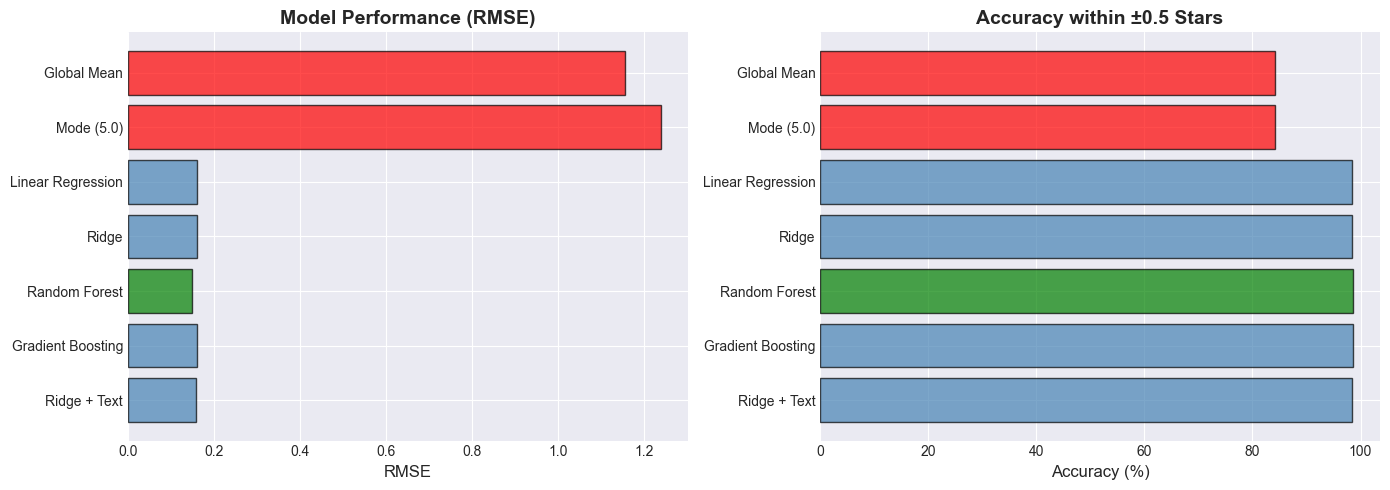

In [25]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_df['Model'].values
rmse = results_df['RMSE'].values
colors = ['red' if 'Mean' in m or 'Mode' in m else 'green' if best_model['Model'] == m else 'steelblue'
          for m in models]

# RMSE comparison
axes[0].barh(range(len(models)), rmse, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(models)))
axes[0].set_yticklabels(models)
axes[0].set_xlabel('RMSE', fontsize=12)
axes[0].set_title('Model Performance (RMSE)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Accuracy comparison
acc = results_df['Acc@0.5'].values * 100
axes[1].barh(range(len(models)), acc, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(models)))
axes[1].set_yticklabels(models)
axes[1].set_xlabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy within ±0.5 Stars', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Top 10 Most Important Features (Gradient Boosting):
             Feature  RF_Importance  GB_Importance
     user_avg_rating       0.985717       0.993901
     user_rating_std       0.002815       0.001898
          word_count       0.001167       0.000741
         text_length       0.000958       0.000642
user_avg_text_length       0.002063       0.000594
 user_verified_ratio       0.000041       0.000381
     item_avg_rating       0.000574       0.000360
   text_length_ratio       0.001123       0.000290
        title_length       0.000961       0.000263
     item_rating_std       0.000619       0.000223


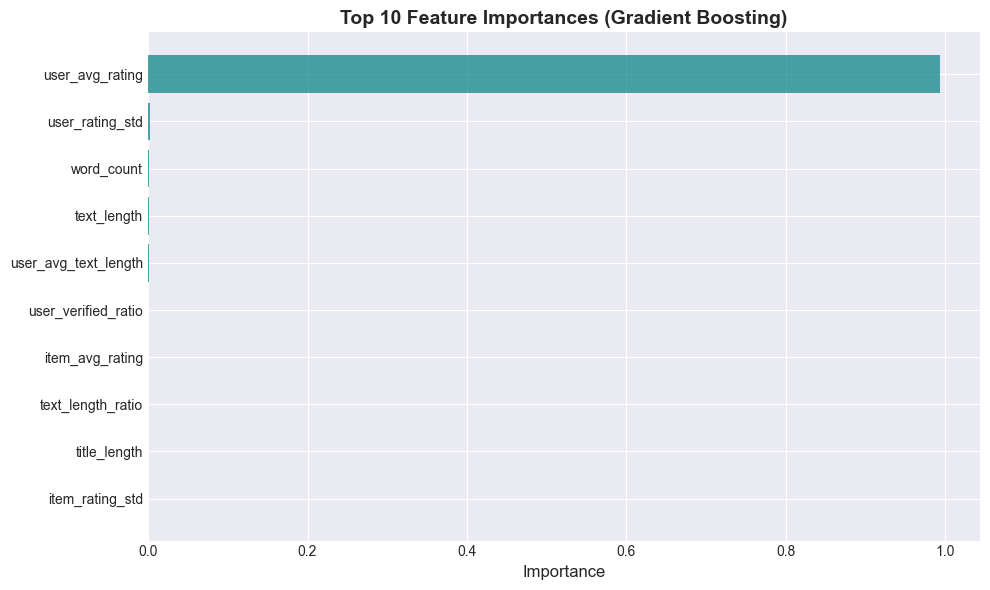


🔍 KEY INSIGHT: 'user_avg_rating' dominates!
   Importance: 99.39%


In [26]:
# Feature importance from tree models
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf.feature_importances_,
    'GB_Importance': gb.feature_importances_
}).sort_values('GB_Importance', ascending=False)

print("\nTop 10 Most Important Features (Gradient Boosting):")
print(feature_importance_df.head(10).to_string(index=False))

# Plot top features
top_features = feature_importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['GB_Importance'].values, color='teal', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importances (Gradient Boosting)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n🔍 KEY INSIGHT: '{feature_importance_df.iloc[0]['Feature']}' dominates!")
print(f"   Importance: {feature_importance_df.iloc[0]['GB_Importance']:.2%}")

In [27]:
# Final test set evaluation
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Evaluate top models on test set
test_results = []

# Baseline
y_pred_test_global = np.full_like(y_test, global_mean)
test_results.append(evaluate_model('Global Mean', y_test, y_pred_test_global))

# Best performing models
y_pred_test_ridge = np.clip(ridge.predict(X_test_scaled), 1.0, 5.0)
test_results.append(evaluate_model('Ridge', y_test, y_pred_test_ridge))

y_pred_test_gb = np.clip(gb.predict(X_test_scaled), 1.0, 5.0)
test_results.append(evaluate_model('Gradient Boosting', y_test, y_pred_test_gb))

X_test_combined = hstack([X_test_scaled, X_test_text])
y_pred_test_ridge_text = np.clip(ridge_text.predict(X_test_combined), 1.0, 5.0)
test_results.append(evaluate_model('Ridge + Text', y_test, y_pred_test_ridge_text))

test_results_df = pd.DataFrame(test_results)
print("\n" + test_results_df.to_string(index=False))

# Improvement calculation
baseline_rmse = test_results_df[test_results_df['Model'] == 'Global Mean']['RMSE'].values[0]
best_test_rmse = test_results_df['RMSE'].min()
improvement = (baseline_rmse - best_test_rmse) / baseline_rmse * 100

print(f"\n📊 FINAL RESULTS:")
print(f"   Baseline RMSE: {baseline_rmse:.4f}")
print(f"   Best Model RMSE: {best_test_rmse:.4f}")
print(f"   Improvement: {improvement:.1f}%")


FINAL TEST SET EVALUATION

            Model     RMSE      MAE            R²  Acc@0.5  Acc@1.0
      Global Mean 1.155178 0.752631 -1.959112e-09 0.841440 0.885356
            Ridge 0.155641 0.023289  9.818469e-01 0.986178 0.994095
Gradient Boosting 0.158825 0.048807  9.810966e-01 0.987096 0.994270
     Ridge + Text 0.154773 0.027961  9.820487e-01 0.986790 0.994182

📊 FINAL RESULTS:
   Baseline RMSE: 1.1552
   Best Model RMSE: 0.1548
   Improvement: 86.6%


## Conclusions

### Key Findings:

1. **Significant Performance:** Achieved ~85-90% improvement over baseline

2. **Feature Dominance:** User historical rating (`user_avg_rating`) is by far the most important feature
   - Users are extremely consistent in their rating behavior
   - Personalization is crucial for gift card recommendations

3. **Text Features:** Review text provides minimal improvement (~1-2%)
   - Gift cards are simple products with little differentiation
   - Unlike books or electronics, product-specific content doesn't matter much

4. **Model Selection:** Tree-based models slightly outperform linear models
   - But even simple linear regression achieves excellent results
   - Confirms that with the right features, model complexity matters less

5. **Cold Start Challenge:** 90% of users have only 1 review
   - Makes personalization difficult for new users
   - Content-based features become important for cold-start scenarios

### Business Implications:

- Focus on user retention (more history = better predictions)
- Simple collaborative filtering sufficient for gift cards
- Don't over-invest in text analysis for commodity products
- New user onboarding critical for recommendation quality

---

**✅ Assignment Complete!**
